# EAS 4610 Final Group Project: Glacial Cycles (Pollard 1982)
### Dennis Frank, Marcus Morris, Nathan Warner

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd

# Introduction

Analysis of oxygen isotopic data has revealed glacial cycles that align with the orbital forcings described in Milankovitch’s orbital cycle theory. Specifically, 100 kyr, 40 kyr, and 20 kyr cycles are present that align with the eccentricity, obliquity, and precession orbital forcings proposed by Milankovitch. It is suggested that these forcings alter the solar flux received by high-latitude regions of the earth, producing these cycles. By modeling ice thickness over time, we seek to better understand the natural processes that control glacial ages and transition periods. A better understanding of these natural processes then enables us to understand how anthropogenic climate forcings affect these high-latitude regions and the greater climate system. 

Previous models have varied by which physical processes to model and how to implement them. For example, Pollard’s 1982 model predicts ice thickness considering the topography, the net annual mass balance of the ice surface, orbital parameters, elastic deformation, and potential ice calving at the tip of the ice sheet. However, the model fails to consider several variables such as east-west topography and the complete elastic response of the lithosphere. Other models prioritize modeling other aspects of glacial cycles, namely seasonality or energy balance. Specifically, Huybers' model considers variation in solar insolation on a seasonal time scale, while Pollard simplified insolation to an average summer half-year value. In our model, we focus on Pollard’s model by exploring the balance between the diffusivity parameter and a constant snowfall flux.

# Equations

The main process that we are attempting to model is the glacial cycle. Due to variations in Earth’s orbital parameters, bedrock level, and topography, these cycles can change. These are represented by 3 main equations from Pollard's model that are explored below. There are other processes that can affect the model, such as ice sheet runoff and ice calving, not explicitly factored into these equations.

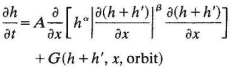

Equation 1 is a diffusion equation where h represents the thickness of the ice in m, h’ represents the bedrock surface elevation in m, x represents the vertical distance to the south from 74°N in m, and t represents time in years. A, alpha, and beta are constants. This equation also takes in another equation, represented by G, which is a function of h, h’, x, and the equilibrium-line altitude E. The equilibrium-line altitude is explored below.


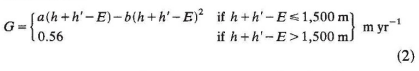

In this equation, a and b are also constants. The equilibrium-line latitude, E, is a linear function with respect to latitude, the difference in the summer half-year insolation at 55°N ΔQ, and insolation sensitivity, k.

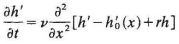

The third equation represents a thin-channel model for the aforementioned processes. In this case, r is the ratio of ice density to rock density, and h’0(x) is the dominating surface topography as a function of distance from 74°N. Nu is a separate expression and is a function of rock density, the thickness and dynamic viscosity of the channel, and gravity.

There are some assumptions made in the original model. East-west flow is neglected, so we are assuming that only north-south flow matters. Minor elastic deformation dynamics are also neglected for the purposes of this model. 
In our model here, we also assume G is constant due to the small time scale used in our model for reasons explored below. We also neglect aforementioned processes, such as ice calving, that could theoretically affect the model in the long-term. 
---------------------------------

In [1]:
#Constants

##Equation 1
A = 5.77e-4 # 1/(m^3 yr)
alpha = 5
beta = 2

##Equation 2
a=0.81e-3 #Snowfall Constant, Unit:(1/yr) 
b=0.3e-6 #Ice Melt Constant, Unit:(1/(m*yr))
k_sens=25 #Insolation Sensitivity (m*day/Ly)
k_sens = k_sens / 41840 # 1 Ly = 41840 J/m^2
S=0 #Elevation of Current Sea Level
pi=917 #ice density (kg/m^3)
pw=1027 #sea water density (kg/m^3)

##Equation 3
r = 0.3
nu = 100 # km^2/yr
nu = nu * 1000 * 1000 # convert to m^2/yr


In [2]:
#Function for Calculating the Mass Balance, G: (Snowfall - Ice Melt)
def G(h,h_prime,h_prev,h_prime_prev,E0,dQ, t_param): #h:ice height, h':bedrock elevation, x:distance, E0:current equilibrium altitude, dq:insolation change @ 65°N
    E = E0 + k_sens*dQ
    H = h+h_prime #Surface Elevation: H=h+h'
#    if (pi*h_prev < (pw*(S-h_prime_prev))) and (h_prime < S): #Calving Conditional Statement
#        return -20
#     if (H-E) <= -1000:
#         return a*(H-E) - b*((H-E)**2)
#     else:
    return 0.56

# Numerical Methods

A Forward Euler marching equation was derived for Equations 1 and 3. Forward Euler was chosen due to the complexity of the equations and ease in implementing in code. A centered difference approximation was used for the first derivatives in Equation 1 since the values in these terms, ultimately h and h', are dependent upon values from forward and backwards space intervals.

The initial conditions for the first simulation were uniformly zero for h and h', respectively representing no ice sheet and a bedrock at sea level at the beginning of the model. For the second simulation, a value of 500m was chosen to represent the initial height of the ice sheet at x = 0.

A Forward Euler marching equation was derived for Equation 1 and is located in Matrix_Derivation.pdf in the git repository. There are Dirichlet boundary conditions of h = 0 at 74°N and 30°N, as derived from the paper, and the first and last rows of the matrix multiplying h were adjusted as such; the matrix multiplying h' set the first and last rows to 0 so that they do not impact the value of h at each time step. 

A Forward Euler marching equation for Equation 3 was ultimately derived by adding the diffusion equations, with respective parameters, of three matrices for the three respective terms in the equation. Like Equation 1, Dirichlet boundary conditions of h' = h'0 = 0 were set at 74°N and 30°N. The matrix multiplying h'0 was set to reflect this, with the other two matrices setting zero for all values in their first and last rows so that they don't impact the value of h'.

Once h was found, a trapezoid rule numerical integration was applied to the columns of h to find the total north-south ice sheet surface area at each time interval. This numerical method was chosen due to its higher level of accuracy compared to the midpoint rule while still being less computationally intensive and complicated to implement than Simpson's Rule.

In [5]:
#Model Parameters
t_f = 1500
x_f = 4884000
dt = 0.01 #yr
dx = 55500 #m
nt = int(t_f/dt) + 1
nx = int(x_f/dx) + 1
x = np.linspace(0, x_f, nx)
t = np.linspace(0, t_f, nt)

c_nu = (nu * dt) / (dx**2)
c_A = (A * dt) / (4*dx**2)

### Model with IC: h(x=0) = 0 m

In [7]:
h1 = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h1[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
for k in np.arange(0, nt - 1):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h1[1:-1,k]**alpha + abs(((h1[2:nx,k] - h1[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = 0
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h1[i, k], h_prime[i, k], h1[i-1, k], h_prime[i-1, k], E0[i], this_dQ, k)
        
    # Find h at next time step
    h_new = h_M@h1[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h1[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h1[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()

KeyboardInterrupt: 

### Model with IC: h(x=0) = 500 m

In [ ]:
h2 = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_0[0] = 500
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h2[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
for k in np.arange(0, nt - 1):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h2[1:-1,k]**alpha + abs(((h2[2:nx,k] - h2[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = 0
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h2[i, k], h_prime[i, k], h2[i-1, k], h_prime[i-1, k], E0[i], this_dQ, k)
        
    # Find h at next time step
    h_new = h_M@h2[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h2[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h2[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()

# Results

### Model with IC: h(x=0) = 0 m

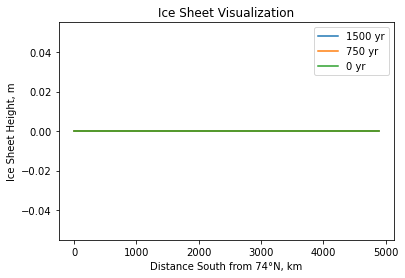

In [8]:
#Ice Sheet Visualization
x_km = x/1000
plt.plot(x_km, h1[:,150000],label= "1500 yr")
plt.plot(x_km, h1[:,int(150000/2)],label= "750 yr")
plt.plot(x_km, h1[:,0],label= "0 yr")

plt.legend()
plt.title("Ice Sheet Visualization")
plt.xlabel("Distance South from 74°N, km")
plt.ylabel("Ice Sheet Height, m")
plt.show()

In [ ]:
#Apply Trapezoid Rule for Numerical Integration of Ice Sheet Cross-Sectional Area
hsum1=np.zeros(nt)
for i in np.arange(0, nt):
    for j in np.arange(0, nx-1):
        hsum1[i] += (h1[j,i] + h1[j+1,i]) * (dx/2)

In [ ]:
#Visualized Cross-Sectional Area
plt.plot(t,hsum1)
plt.title("Ice Sheet Cross-Sectional Area")
plt.xlabel("Year")
plt.ylabel("Cross-Sectional Area, m²")
plt.show()

### Model with IC: h(x=0) = 500 m

In [ ]:
#Ice Sheet Visualization
x_km = x / 1000
plt.plot(x_km, h2[:,150000],label= "1500 yr")
plt.plot(x_km, h2[:,int(150000/2)],label= "750 yr")
plt.plot(x_km, h2[:,0],label= "0 yr")

plt.title("Ice Sheet Visualization")
plt.xlabel("Distance South from 74°N, km")
plt.ylabel("Ice Sheet Height, m")
plt.legend()
plt.show()

In [ ]:
#Apply Trapezoid Rule for Numerical Integration of Ice Sheet Cross-Sectional Area
hsum2=np.zeros(nt)
for i in np.arange(0, nt):
    for j in np.arange(0, nx-1):
        hsum2[i] += (h2[j,i] + h2[j+1,i]) * (dx/2)

In [ ]:
#Visualized Cross-Sectional Area
plt.plot(t,hsum2)
plt.title("Ice Sheet Cross-Sectional Area")
plt.xlabel("Year")
plt.ylabel("Cross-Sectional Area, m²")
plt.show()

In our model, we ran two main simulations with varying initial conditions. Specifically, we tested the effect that the initial ice sheet height at x = 0 m would have on the model, using values of 0 meters and 500 meters to visualize this. 
Unfortunately, we were unable to get the model to run over the entire intended time period of 700 kyr. To stabilize the model, we had to lower our time frame and use the smallest time step we could as we expanded the time range the model covers. Through trial and error, we selected a time range of 1500 years and a time step of 0.01 years we could model without encountering errors that ran in a reasonable amount of time. This means we were not able to see all of the distinct oscillations in the ice sheet cross-sectional area that the model in the original paper showed. However, for the length of the time periods we were able to run the model in, we were able to see that the cross-sectional area of the ice sheet reaches a steady state over time, with a similar magnitude on a scale of 10^9 m^2 compared to Pollard's model. The shape of the ice sheets in simulation 1 also matches that found at the 18 kyr time step in Pollard's model.

Between our simulations, we achieved similar results, but were able to demonstrate an effect from the differences in the initial conditions we set. Both simulations eventually reached a steady state in the ice sheet cross-sectional area, but the simulation where the initial height was set to 500 meters had a greater height as it’s steady state. Glacier area reached the same maximum height of approximately 500 meters for both runs with the height decreasing from this maximum as distance from the poles increased. The peak increased with time in both figures, similar to the increasing trend for the cross-sectional area plots. As the second run started at an initial height of 500 meters it followed the same trend as the second half of the first run. The steady state reached by the model physically represnts a balance between the constant additional snowfall and the diffusivity of the ice sheet. If we were able to model a sinusoidal trend from the orbital parameter in the second equation, we would expect to see the cycles present in Pollard's model.

There are several ways our model could be improved. Unsurprisingly, if we were able to get the model to successfully run over the entire intended time period, the results would be better at modeling the pattern evident in the isotopic data. With longer term data it would also be possible to conduct spectral analysis to see the prevelance of cerntain frequencies in our model.

# Video Walkthrough

# References

Huybers, P., and Tziperman, E. (2008), *Integrated summer insolation forcing and 40,000-year glacial cycles: The perspective from an ice-sheet/energy-balance model*, Paleoceanography, 23, PA1208, doi:10.1029/2007PA001463.

Pollard, D. (1982), *A simple ice sheet model yields realistic 100 kyr glacial cycles.* Nature 296, 334–338, https://doi.org/10.1038/296334a0